Using device: mps
Estimated Crowd Size: 250


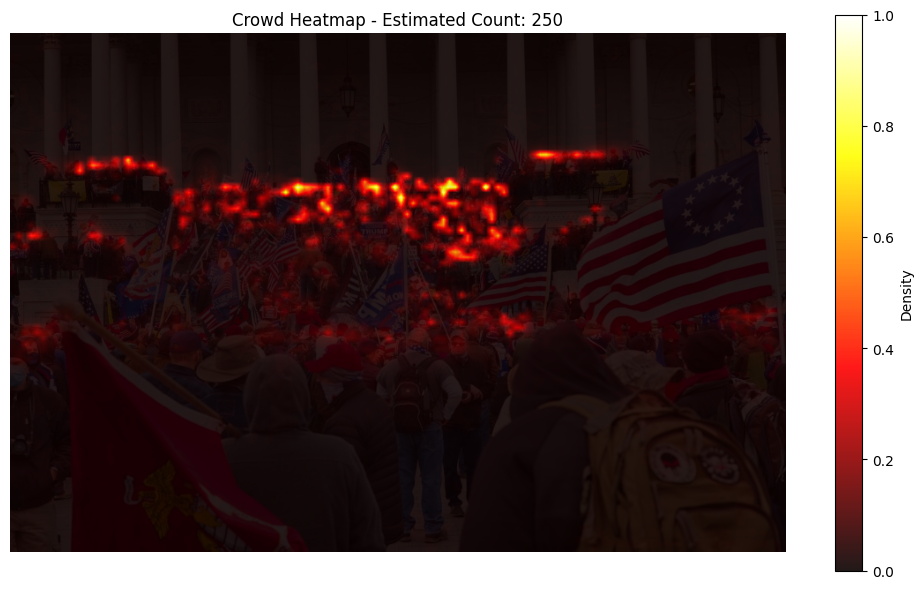

In [15]:
import cv2
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from torchvision import models, transforms
from ultralytics import YOLO
from PIL import Image

# CSRNet class and make_layers function remain the same as you already have in your original code

# Device selection with Apple MPS support
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        
        # Frontend feature extraction (based on VGG16)
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        # Backend feature processing
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        # Create layers for frontend and backend
        self.frontend = make_layers(self.frontend_feat)  # Feature extractor layers
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)  # Backend layers with dilation
        
        # Output layer to create the density map
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            # Load pre-trained VGG16 weights and initialize layers
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            
            # Transfer the pre-trained VGG16 weights to the frontend
            frontend_state_dict = self.frontend.state_dict()
            mod_state_dict = mod.state_dict()
            
            for i, (key, value) in enumerate(frontend_state_dict.items()):
                frontend_state_dict[key].copy_(mod_state_dict[list(mod_state_dict.keys())[i]])

    def forward(self, x):
        # Forward pass through frontend, backend, and output layer
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        # Custom weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# Helper function to make layers from configuration
def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    layers = []
    d_rate = 2 if dilation else 1  # Dilation rate for convolutions
    
    for v in cfg:
        if v == 'M':
            # Max pooling layer
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            # Convolutional layer with optional batch normalization
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

# Initialize CSRNet and load pre-trained weights
csrnet_model = CSRNet(load_weights=False)
weights_path = "CrowdCountingWeights.pth"  # Provide your local path to CSRNet weights
checkpoint = torch.load(weights_path, map_location=device)
csrnet_model.load_state_dict(checkpoint)
csrnet_model.eval()
csrnet_model.to(device)

# Image transformation for CSRNet (normalization and resizing)
csrnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((768, 1024)),  # Resize the input to match CSRNet's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to estimate the crowd size and overlay density map as heatmap
# Function to estimate the crowd size and overlay density map as heatmap
def estimate_crowd_and_heatmap(image_path, model, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size[::-1]  # (height, width)
    
    # Transform for model input
    transform = transforms.Compose([
        transforms.Resize((768, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformation and estimate density map
    input_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        density_map = model(input_tensor).squeeze().cpu().numpy()

    # Estimate total crowd size
    total_people = int(np.sum(density_map))
    print(f'Estimated Crowd Size: {total_people}')

    # Resize density map to original image size
    density_map_resized = cv2.resize(density_map, (original_size[1], original_size[0]))
    
    # Normalize the density map for visualization
    density_map_normalized = (density_map_resized - density_map_resized.min()) / (density_map_resized.max() - density_map_resized.min())

    # Plot heatmap on original image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.imshow(density_map_normalized, cmap='hot', alpha=0.9)
    plt.colorbar(label='Density')
    plt.title(f'Crowd Heatmap - Estimated Count: {total_people}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test with an input image
image_path = '90.jpeg'  
estimate_crowd_and_heatmap(image_path, csrnet_model, device)